I put the onehotencoder and train test split near the end of feature negineering. Use X_train_encoded and X_test_encoded as your train and test x's - Alex

In [ ]:
# Load libraries
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
%pylab inline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
!pip install shap
import shap
import os
current_directory = os.getcwd()
print(current_directory)

# Read in file
walmart = pd.read_csv('Walmart_Store_sales.csv', index_col='Store')

Populating the interactive namespace from numpy and matplotlib
/content


#Data Exploration

<Axes: title={'center': 'Mean of Weekly Sales Across All Stores by Month'}, xlabel='Date'>

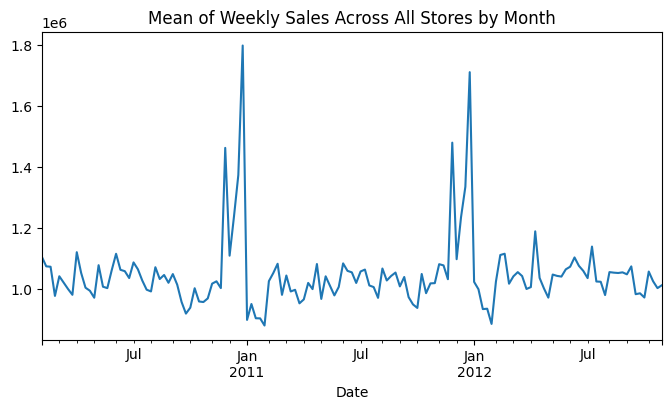

In [ ]:
#Grouped the store by their date, found the mean sales across all the stores and plotted them across the given time frame
# Date to datetime format for analysis
walmart['Date'] = walmart['Date'].str.replace('/', '-', regex=False)
walmart['Date'] = pd.to_datetime(walmart['Date'], format='%d-%m-%Y')

#Group by year and month, calculate the mean of 'Weekly_Sales', and plot
walmart.groupby(pd.Grouper(key='Date', freq='W'))['Weekly_Sales'].mean().plot(
    kind='line',
    figsize=(8, 4),
    title='Mean of Weekly Sales Across All Stores by Month',
    legend=False
)

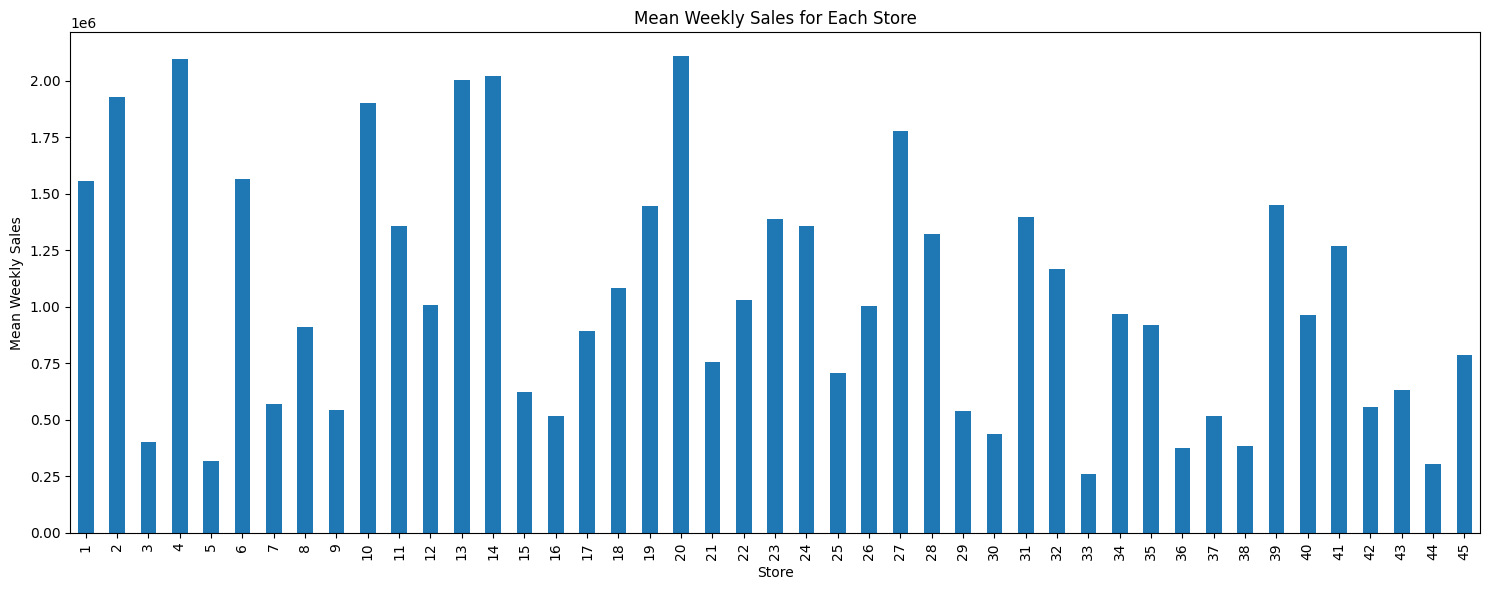

In [ ]:
# Group by store and calculate the mean of 'Weekly_Sales'
store_weekly_sales = walmart.groupby('Store')['Weekly_Sales'].mean()

# Plot the mean weekly sales for each store
plt.figure(figsize=(15, 6))  # Adjust figure size as needed
store_weekly_sales.plot(kind='bar')
plt.title('Mean Weekly Sales for Each Store')
plt.xlabel('Store')
plt.ylabel('Mean Weekly Sales')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


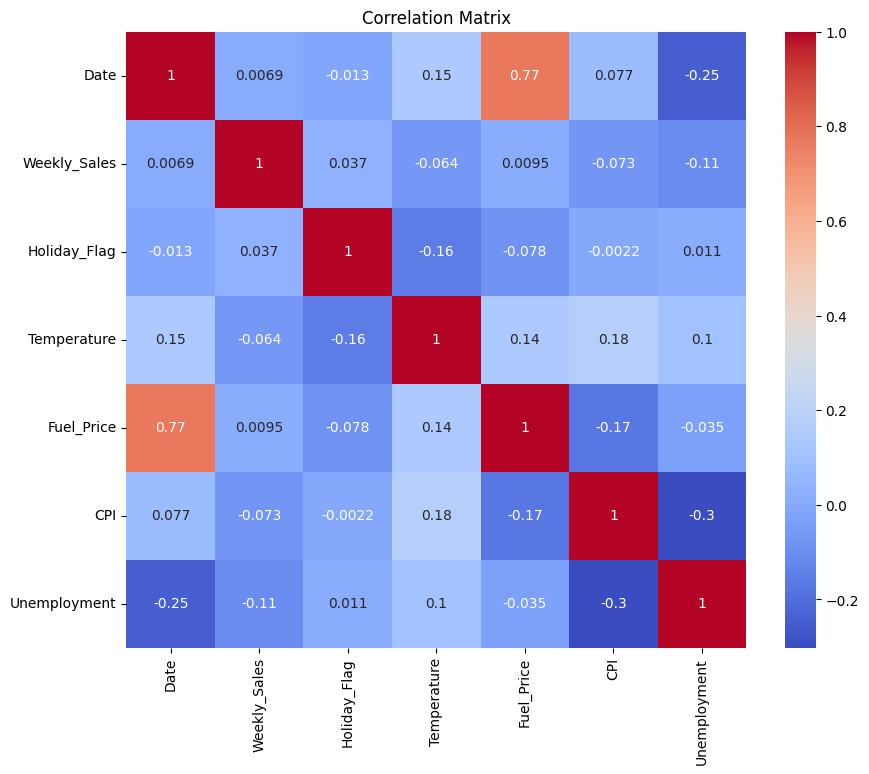

In [ ]:
# Correlation plot
corr = walmart.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Generate summary statistics
walmart.describe(include='all')

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


#Feature Engineering

In [ ]:
#removing store number from index

walmart.reset_index(inplace=True)
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
#adding distance from average temperature

average_temp = walmart.groupby('Store')['Temperature'].transform('mean')
average_temp.value_counts()

,count
Temperature,
68.847622,429
70.262797,429
72.241189,286
57.790979,286
53.697133,286
57.311119,286
54.897133,286
71.160350,286
76.728182,143


In [ ]:
  walmart['temp_distance'] = walmart['Temperature'] - average_temp
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,temp_distance
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,-25.996783
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,-29.796783
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,-28.376783
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,-21.676783
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,-21.806783


In [ ]:
#creating distance from average columns for other variables

average_fuel_price = walmart.groupby('Store')['Fuel_Price'].transform('mean')
average_cpi = walmart.groupby('Store')['CPI'].transform('mean')
average_unemployment = walmart.groupby('Store')['Unemployment'].transform('mean')

walmart['fuel_price_distance'] = walmart['Fuel_Price'] - average_fuel_price
walmart['cpi_distance'] = walmart['CPI'] - average_cpi
walmart['unemployment_distance'] = walmart['Unemployment'] - average_unemployment

walmart[:20]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,temp_distance,fuel_price_distance,cpi_distance,unemployment_distance
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,-25.996783,-0.647699,-4.900534,0.49558
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,-29.796783,-0.671699,-4.754722,0.49558
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,-28.376783,-0.705699,-4.707749,0.49558
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,-21.676783,-0.658699,-4.677249,0.49558
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,-21.806783,-0.594699,-4.646749,0.49558
5,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,-10.516783,-0.552699,-4.616249,0.49558
6,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,-13.726783,-0.499699,-4.781257,0.49558
7,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,-16.856783,-0.487699,-4.978849,0.49558
8,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808,-6.036783,-0.500699,-5.176442,0.19758
9,1,2010-04-09,1545418.53,0,65.86,2.770,210.622857,7.808,-2.446783,-0.449699,-5.374034,0.19758


In [ ]:
#creating distance from average columns for other variables

national_average_fuel_price = walmart.groupby('Date')['Fuel_Price'].transform('mean')
national_average_cpi = walmart.groupby('Date')['CPI'].transform('mean')
national_average_unemployment = walmart.groupby('Date')['Unemployment'].transform('mean')

walmart['fuel_price_distance_national_avg'] = walmart['Fuel_Price'] - average_fuel_price
walmart['cpi_distance_national_avg'] = walmart['CPI'] - average_cpi
walmart['unemployment_distance_national_avg'] = walmart['Unemployment'] - average_unemployment

walmart[:20]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,temp_distance,fuel_price_distance,cpi_distance,unemployment_distance,fuel_price_distance_national_avg,cpi_distance_national_avg,unemployment_distance_national_avg
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,-25.996783,-0.647699,-4.900534,0.49558,-0.647699,-4.900534,0.49558
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,-29.796783,-0.671699,-4.754722,0.49558,-0.671699,-4.754722,0.49558
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,-28.376783,-0.705699,-4.707749,0.49558,-0.705699,-4.707749,0.49558
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,-21.676783,-0.658699,-4.677249,0.49558,-0.658699,-4.677249,0.49558
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,-21.806783,-0.594699,-4.646749,0.49558,-0.594699,-4.646749,0.49558
5,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,-10.516783,-0.552699,-4.616249,0.49558,-0.552699,-4.616249,0.49558
6,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,-13.726783,-0.499699,-4.781257,0.49558,-0.499699,-4.781257,0.49558
7,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,-16.856783,-0.487699,-4.978849,0.49558,-0.487699,-4.978849,0.49558
8,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808,-6.036783,-0.500699,-5.176442,0.19758,-0.500699,-5.176442,0.19758
9,1,2010-04-09,1545418.53,0,65.86,2.770,210.622857,7.808,-2.446783,-0.449699,-5.374034,0.19758,-0.449699,-5.374034,0.19758


In [ ]:
walmart.shape

(6435, 15)

In [ ]:
#log transforming weekly sales

walmart['Weekly_Sales'] = np.log(walmart['Weekly_Sales'])
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,temp_distance,fuel_price_distance,cpi_distance,unemployment_distance,fuel_price_distance_national_avg,cpi_distance_national_avg,unemployment_distance_national_avg
0,1,2010-02-05,14.312455,0,42.31,2.572,211.096358,8.106,-25.996783,-0.647699,-4.900534,0.49558,-0.647699,-4.900534,0.49558
1,1,2010-02-12,14.311400,1,38.51,2.548,211.242170,8.106,-29.796783,-0.671699,-4.754722,0.49558,-0.671699,-4.754722,0.49558
2,1,2010-02-19,14.292966,0,39.93,2.514,211.289143,8.106,-28.376783,-0.705699,-4.707749,0.49558,-0.705699,-4.707749,0.49558
3,1,2010-02-26,14.158907,0,46.63,2.561,211.319643,8.106,-21.676783,-0.658699,-4.677249,0.49558,-0.658699,-4.677249,0.49558
4,1,2010-03-05,14.256862,0,46.50,2.625,211.350143,8.106,-21.806783,-0.594699,-4.646749,0.49558,-0.594699,-4.646749,0.49558


#**Models**

# Splitting Data (CV)

In [ ]:
X = walmart.drop(columns=['Weekly_Sales'])
y = walmart['Weekly_Sales']

# Step 2: Split Data into Train and Test Sets (features and target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Ensure Test Set Includes All Store Numbers (if needed)
# Create test set with at least one of every store number
unique_stores = X['Store'].unique()
test_set = pd.DataFrame()
for store in unique_stores:
    store_data = X[X['Store'] == store]
    test_set = pd.concat([test_set, store_data.sample(1)])

remaining_data = X.drop(test_set.index)
X_train, X_test_remaining = train_test_split(remaining_data, test_size=0.2, random_state=42)
X_test = pd.concat([X_test_remaining, test_set]).drop_duplicates()

# Extract corresponding target values for train and test
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

combined = pd.concat([X_train, X_test], axis=0)
combined_encoded = pd.get_dummies(combined, columns=['Store'])

# Split the encoded DataFrame back into train and test
X_train_encoded = combined_encoded.iloc[:len(X_train)]
X_test_encoded = combined_encoded.iloc[len(X_train):]

# Ensure that both encoded DataFrames have the same columns
all_columns = X_train_encoded.columns
X_train_encoded = X_train_encoded.reindex(columns=all_columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=all_columns, fill_value=0)

# Print results
print("Training Features (One-Hot Encoded):")
print(X_train_encoded)
print("\nTraining Target:")
print(y_train)
print("\nTest Features (One-Hot Encoded):")
print(X_test_encoded)
print("\nTest Target:")
print(y_test)

Training Features (One-Hot Encoded):
           Date  Holiday_Flag  Temperature  Fuel_Price         CPI  \
6122 2012-04-27             0        78.27       3.814  213.062819   
2288 2010-02-05             0        23.11       2.666  126.442065   
3484 2011-02-04             0        23.94       3.231  205.732941   
5330 2010-11-05             0        65.49       3.129  126.491290   
4389 2011-12-30             1        45.16       3.129  219.177306   
...         ...           ...          ...         ...         ...   
3799 2011-08-26             0        72.88       3.906  140.162953   
5228 2011-08-19             0        87.24       3.554  214.423993   
5263 2012-04-20             0        70.87       3.877  220.248394   
5428 2012-09-21             0        82.97       4.125  131.010333   
866  2010-04-02             0        38.26       2.725  189.704822   

      Unemployment  temp_distance  fuel_price_distance  cpi_distance  \
6122         9.575       9.392308             0.59

In [ ]:
#dropping date

X_train_encoded.drop(columns=['Date'], inplace=True)
X_test_encoded.drop(columns=['Date'], inplace=True)

# Multiple Regression

In [ ]:
# Convert boolean columns to float
X_train_encoded = X_train_encoded.astype(float)
X_test_encoded = X_test_encoded.astype(float)

# Fit multiple regression model
X_train_const = sm.add_constant(X_train_encoded)
model = sm.OLS(y_train, X_train_const)
results = model.fit()

# Print summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2422.
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:19:07   Log-Likelihood:                 3664.5
No. Observations:                5112   AIC:                            -7229.
Df Residuals:                    5062   BIC:                            -6902.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [ ]:
# Predict on test set
X_test_const = sm.add_constant(X_test_encoded)
y_pred = results.predict(X_test_const)

# Exponentiate predictions and actual values to reverse log transformation
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)

# Evaluate model
mse = mean_squared_error(y_test_exp, y_pred_exp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_exp, y_pred_exp)

# Round to two decimal places
mse_rounded = round(mse, 2)
rmse_rounded = round(rmse, 2)
r2_rounded = round(r2, 2)

# Print performance metrics
print("Mean Squared Error:", mse_rounded)
print("Root Mean Squared Error:", rmse_rounded)
print("R-squared:", r2_rounded)


Mean Squared Error: 37945437320.26
Root Mean Squared Error: 194795.89
R-squared: 0.89


# Regression Tree

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1    5/2/2010    1643690.90             0        42.31       2.572   
1      1   12/2/2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1    5/3/2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


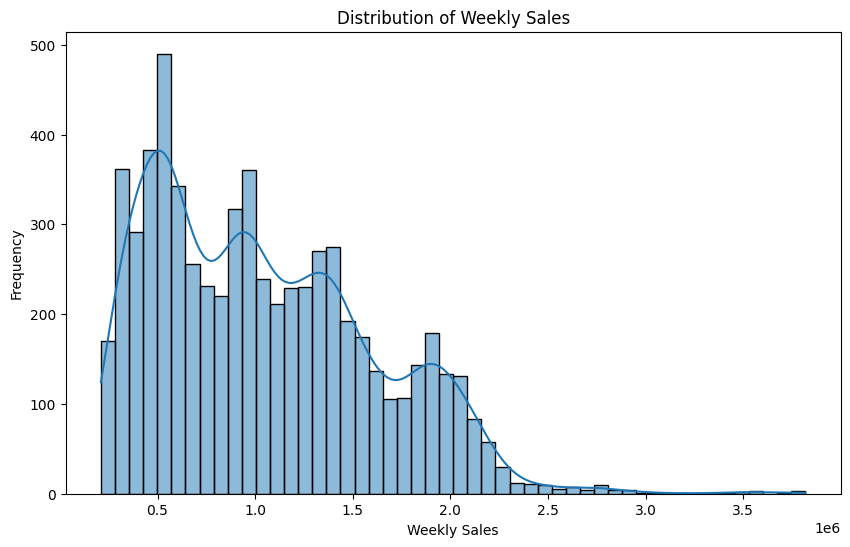

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
#Data examination with barplot and heatmap
df = pd.read_csv('Walmart_Store_sales.csv')
df.columns.values
print(df.head())
df.dtypes
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], bins=50, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))


In [ ]:
X = walmart.drop(columns=['Weekly_Sales'])
y = walmart['Weekly_Sales']

# Step 2: Split Data into Train and Test Sets (features and target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Ensure Test Set Includes All Store Numbers (if needed)
# Create test set with at least one of every store number
unique_stores = X['Store'].unique()
test_set = pd.DataFrame()
for store in unique_stores:
    store_data = X[X['Store'] == store]
    test_set = pd.concat([test_set, store_data.sample(1)])

remaining_data = X.drop(test_set.index)
X_train, X_test_remaining = train_test_split(remaining_data, test_size=0.2, random_state=42)
X_test = pd.concat([X_test_remaining, test_set]).drop_duplicates()

# Extract corresponding target values for train and test
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

combined = pd.concat([X_train, X_test], axis=0)
combined_encoded = pd.get_dummies(combined, columns=['Store'])

# Split the encoded DataFrame back into train and test
X_train_encoded = combined_encoded.iloc[:len(X_train)]
X_test_encoded = combined_encoded.iloc[len(X_train):]

# Ensure that both encoded DataFrames have the same columns
all_columns = X_train_encoded.columns
X_train_encoded = X_train_encoded.reindex(columns=all_columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=all_columns, fill_value=0)

# Print results
print("Training Features (One-Hot Encoded):")
print(X_train_encoded)
print("\nTraining Target:")
print(y_train)
print("\nTest Features (One-Hot Encoded):")
print(X_test_encoded)
print("\nTest Target:")
print(y_test)

Training Features (One-Hot Encoded):
           Date  Holiday_Flag  Temperature  Fuel_Price         CPI  \
6122 2012-04-27             0        78.27       3.814  213.062819   
2288 2010-02-05             0        23.11       2.666  126.442065   
3484 2011-02-04             0        23.94       3.231  205.732941   
5329 2010-10-29             0        61.09       3.016  126.436419   
4389 2011-12-30             1        45.16       3.129  219.177306   
...         ...           ...          ...         ...         ...   
3798 2011-08-19             0        72.97       3.942  140.128920   
5228 2011-08-19             0        87.24       3.554  214.423993   
5263 2012-04-20             0        70.87       3.877  220.248394   
5428 2012-09-21             0        82.97       4.125  131.010333   
866  2010-04-02             0        38.26       2.725  189.704822   

      Unemployment  temp_distance  fuel_price_distance  cpi_distance  \
6122         9.575       9.392308             0.59

In [ ]:
from sklearn import tree
tree_model = DecisionTreeRegressor(random_state = 40)

In [ ]:
#predicting the testing set
tree_model.fit(X_train_encoded, y_train)

tree_predictions = tree_model.predict(X_test_encoded)
y_test = np.exp(y_test)
tree_predictions = np.exp(tree_predictions)
print('MSE:', mean_squared_error(X_test, tree_predictions))
print('MAE:', (mean_absolute_error(X_test, tree_predictions)))
print('R2:', r2_score(X_test, tree_predictions))

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

# XGBoost

,Store
6122,43
2288,17
3484,25
5329,38
4388,31
...,...
3799,27
5227,37
5263,37
5428,38


In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 50, reg_alpha = 0,reg_lambda = 0, learning_rate=0.1, min_split_loss=0.1,max_depth=8,tree_method='exact')

xgb_model.fit(X_train_encoded, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, min_split_loss=0.1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
xgb_predictions = xgb_model.predict(X_test_encoded)
y_test = np.exp(y_test)
xgb_predictions = np.exp(xgb_predictions)
print('MSE:', mean_squared_error(y_test, xgb_predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, xgb_predictions)))
print('MAE:', (mean_absolute_error(y_test, xgb_predictions)))
print('R2:', r2_score(y_test, xgb_predictions))

MSE: 49322489198.87284
RMSE: 222086.67046644838
MAE: 132185.5475547997
R2: 0.8554940883883289


#Analysis

Feature importances

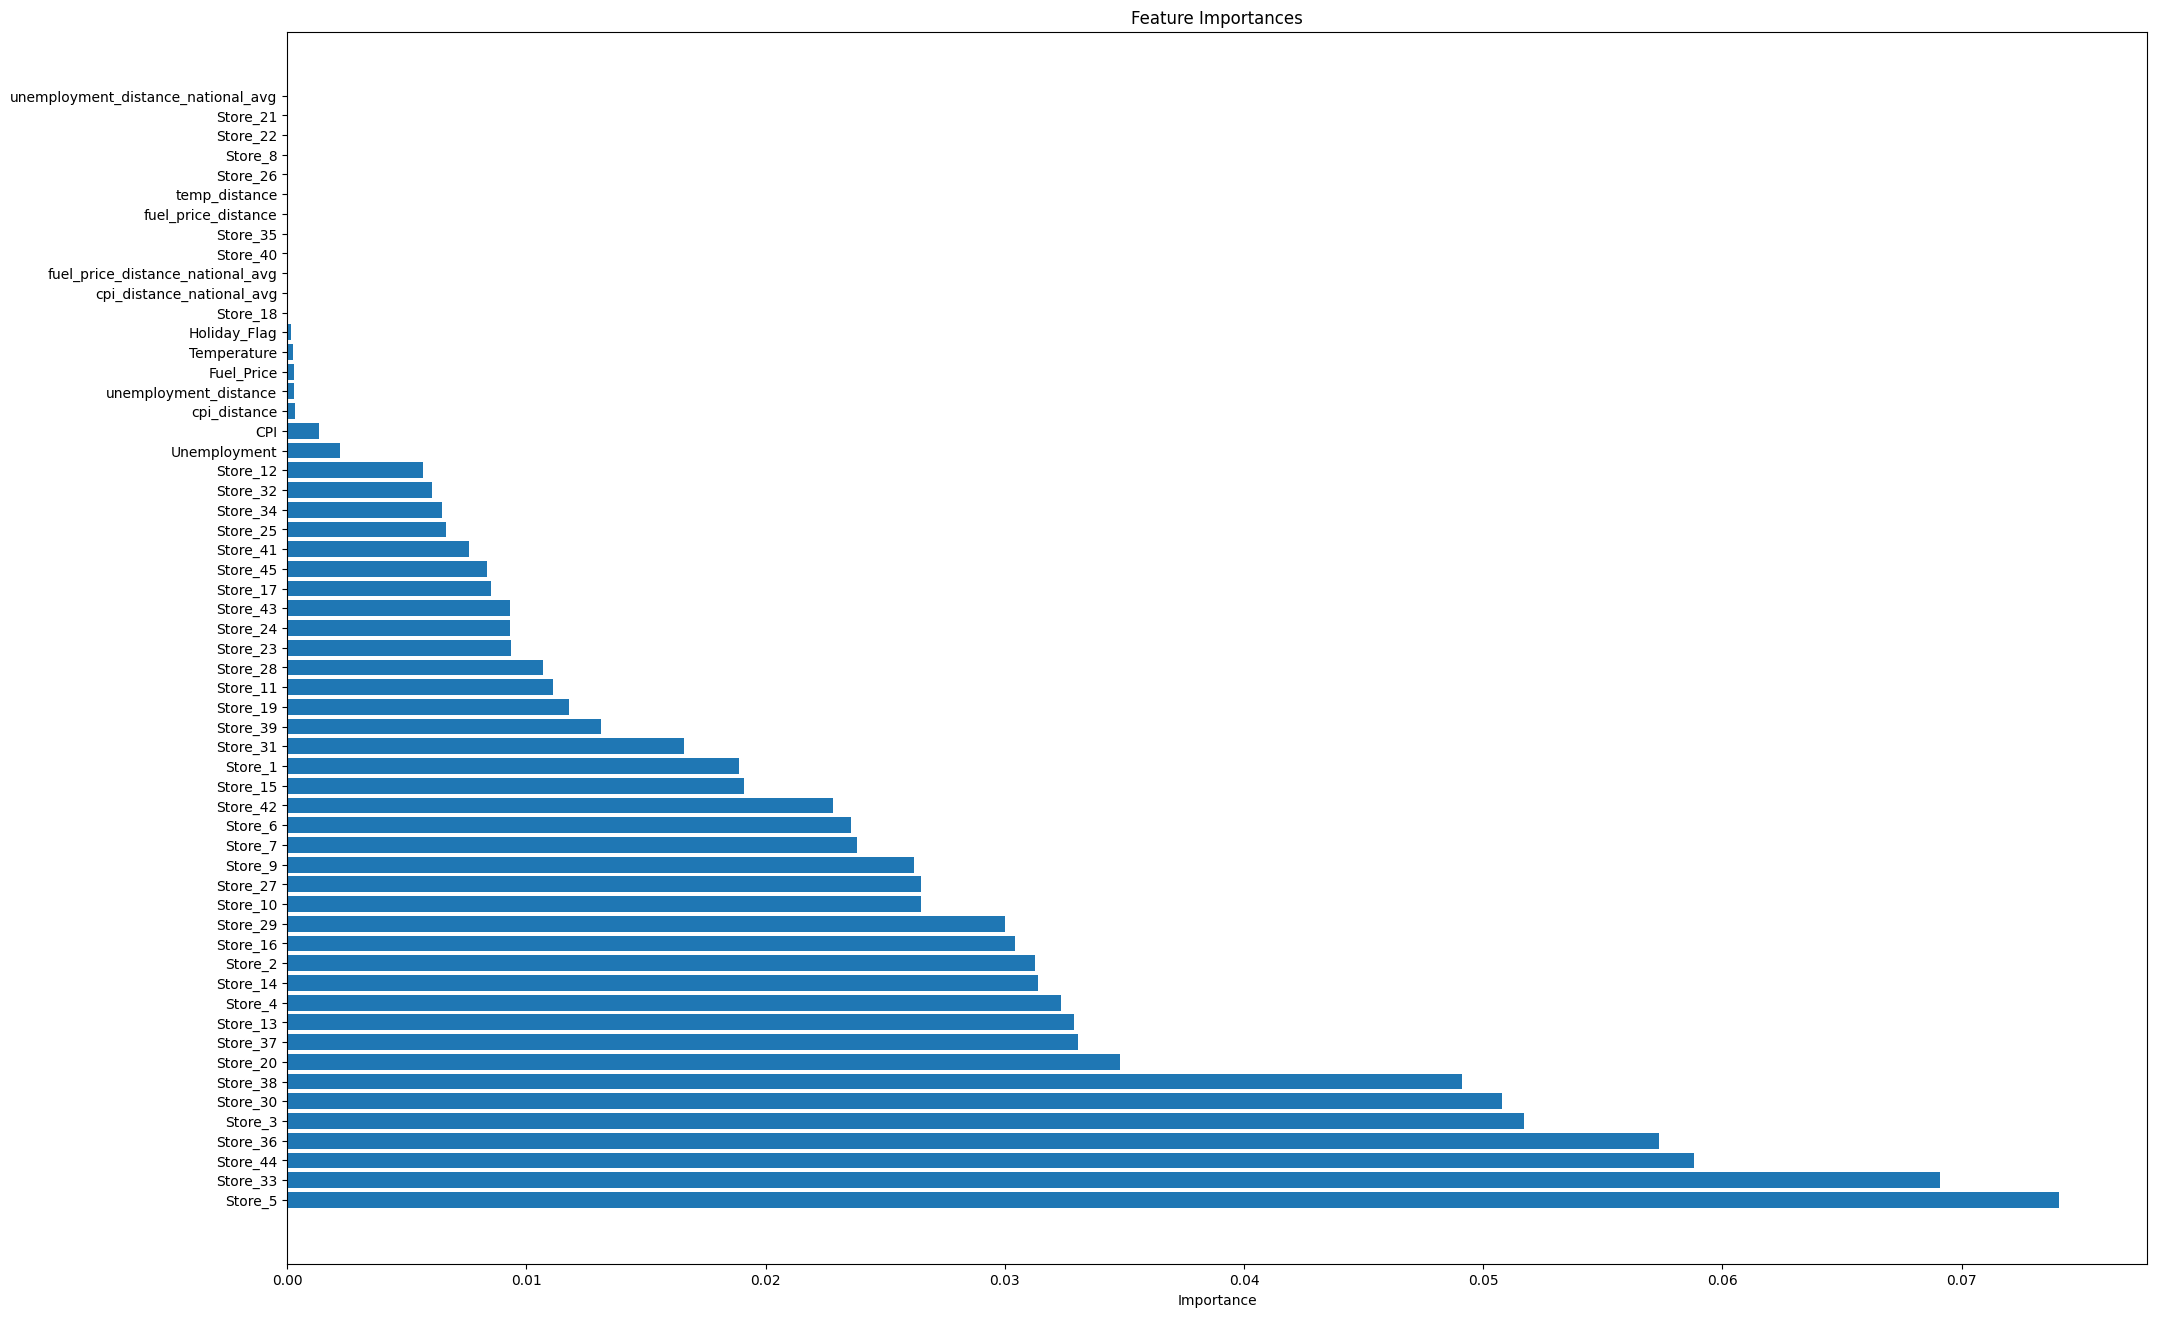

In [ ]:
importances = xgb_model.feature_importances_

# Sort the importances in descending order
indices = np.argsort(importances)[::-1]
sorted_feature_names = [X_train_encoded.columns[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(24, 16))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), sorted_feature_names)
plt.xlabel("Importance")
plt.show()

Shapley values

In [ ]:
feature_names = X_train_encoded.columns.tolist()

# Step 2: Ensure All Relevant Columns Are Converted from bool to int
# Replace 'bool_column_name' with the actual boolean columns, or use a pattern if many columns are boolean
store_columns = [col for col in X_train_encoded.columns if 'store' in col.lower() and X_train_encoded[col].dtype == 'bool']

# Convert boolean columns to int
X_train_encoded[store_columns] = X_train_encoded[store_columns].astype(int)
X_test_encoded[store_columns] = X_test_encoded[store_columns].astype(int)

# Step 2: Initialize SHAP Explainer
explainer = shap.Explainer(xgb_model, X_train_encoded, feature_names=feature_names)

shap_values = explainer(X_test_encoded)

print("Shape of SHAP values:", shap_values.values.shape)
print("SHAP values for the first sample:", shap_values.values[0])

# Check the base values (expected values)
print("Base values:", shap_values.base_values[0])

# Ensure that the feature names match the columns of X_test
print("Feature names from SHAP:", shap_values.feature_names)
print("Columns in X_test:", X_test.columns)

Shape of SHAP values: (1323, 57)
SHAP values for the first sample: [ 1.18966354e-05  1.65302922e-03  1.16697054e-04  8.39362293e-02
 -2.20776023e-02  0.00000000e+00  0.00000000e+00 -5.74642234e-05
 -4.04579705e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.98766924e-03 -6.61411268e-03  1.21348802e-02 -1.21848571e-02
  7.96718415e-03 -7.79921083e-03  7.60072844e-03  0.00000000e+00
  6.52137224e-03 -9.90469445e-03 -1.22537444e-02 -2.37327144e-04
 -1.13794970e-02 -2.22230064e-02  7.62509282e-03  1.35887139e-02
  6.51763305e-04  0.00000000e+00 -2.25511069e-03 -6.73582471e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.04321099e-03
  3.40638988e-03  0.00000000e+00 -1.56168067e-02 -4.37359019e-03
  1.82171412e-02  1.02503258e-02 -8.92904771e-03 -1.29229822e-03
  2.46536698e-02 -9.84786637e-05  0.00000000e+00  3.06852969e-02
  1.81989073e-02  7.54542191e-03 -3.47137938e-03  0.00000000e+00
 -3.87724621e-03  0.00000000e+00  2.05969930e-03  1.06074798e-02
  3.62431318e-03]
Base 

In [ ]:
unique_stores

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

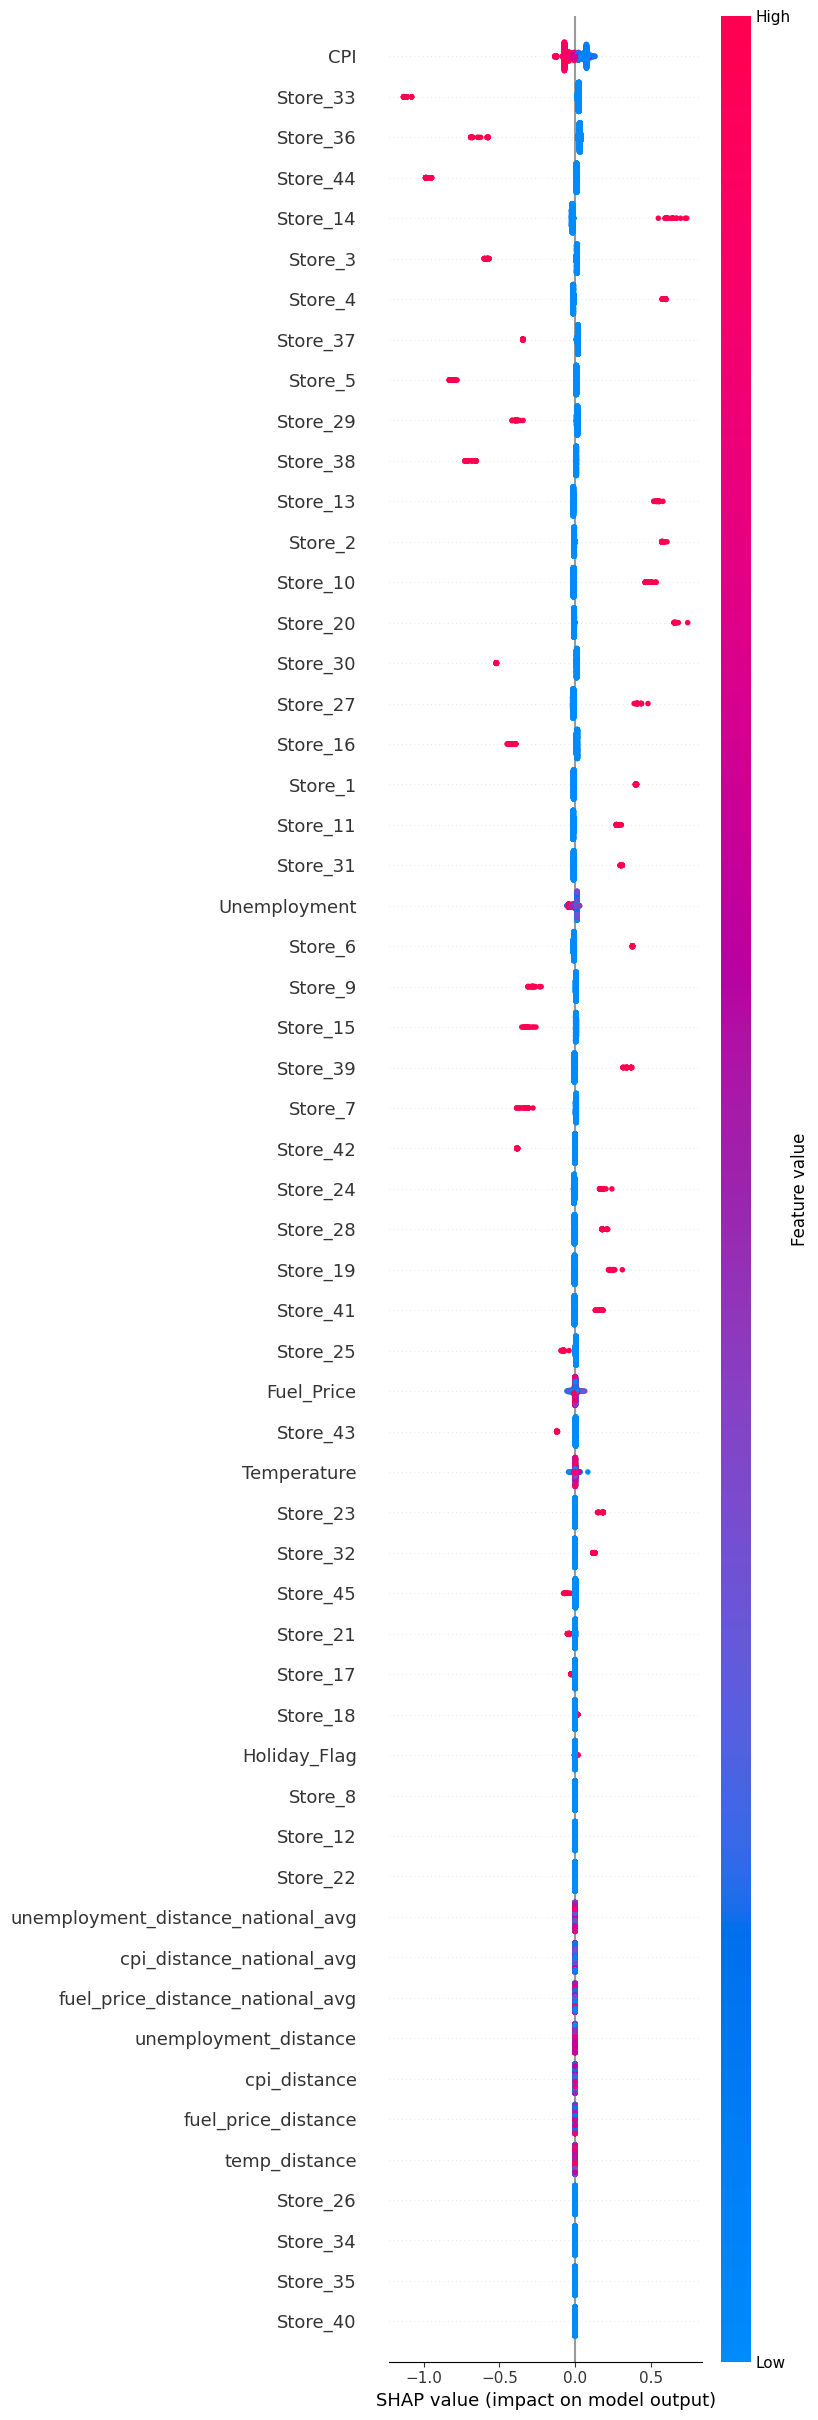

In [ ]:
plt.figure(figsize=(44, 32))
shap.summary_plot(shap_values, X_test_encoded,feature_names=shap_values.feature_names, max_display = 60)


In [ ]:
X_test_encoded

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,temp_distance,fuel_price_distance,cpi_distance,unemployment_distance,fuel_price_distance_national_avg,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
2517,0,69.01,3.684,136.419500,8.890,15.638741,0.242259,1.326893,0.051699,0.242259,...,False,False,False,False,False,False,False,False,False,False
4795,0,80.75,3.627,129.150774,10.641,22.254126,0.410028,0.471105,0.706196,0.410028,...,False,False,False,False,False,False,False,False,False,False
1848,0,79.40,3.545,130.790968,5.765,25.702867,0.258853,2.111298,-1.236825,0.258853,...,False,False,False,False,False,False,False,False,False,False
3126,0,66.56,3.683,142.129255,7.671,11.662867,0.241259,3.117971,-0.398371,0.241259,...,False,False,False,False,False,False,False,False,False,False
4542,0,39.90,3.286,196.963160,8.256,-12.847552,0.044441,3.298917,-0.329734,0.044441,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5816,0,17.05,3.331,195.874257,6.759,-31.360350,0.089441,2.210015,-0.214378,0.089441,...,False,False,False,False,False,True,False,False,False,False
5864,1,49.96,2.828,126.496258,9.765,-22.281189,-0.747923,-2.183411,1.402035,-0.747923,...,False,False,False,False,False,False,True,False,False,False
6042,0,68.78,2.720,203.729903,10.210,-0.097692,-0.499699,-4.005259,0.275196,-0.499699,...,False,False,False,False,False,False,False,True,False,False
6178,0,75.31,2.854,126.089290,7.804,21.612867,-0.432147,-2.590379,1.068378,-0.432147,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
obs_1 = X_test_encoded.loc[4795]
#obs_1
obs_1_reshaped = obs_1.values.reshape(1, -1)
prediction_1 = xgb_model.predict(obs_1_reshaped)

print(f"The predicted value is: {prediction_1[0]}")

NameError: name 'X_test_encoded' is not defined

In [ ]:
prediction_1[0]

NameError: name 'prediction_1' is not defined

In [ ]:
explainer = shap.Explainer(xgb_model, X_train_encoded, feature_names=feature_names)

shap_values = explainer(prediction_1)
shap.plots.waterfall(shap_values[0],show=True)

#plt.show()
plt.close()

IndexError: invalid index to scalar variable.

In [ ]:
obs_2 = X_test_encoded.loc[5722]
#obs_1
obs_2_reshaped = obs_2.values.reshape(1, -1)
prediction_2 = xgb_model.predict(obs_2_reshaped)

print(f"The predicted value is: {prediction_2[0]}")

shap_values = explainer(prediction_2)
shap.plots.waterfall(shap_values[0],show=True)

#plt.show()
plt.close()

In [ ]:
#KNN Regressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize variables to store the best results
best_n_neighbors = None
lowest_rmse = float('inf')
best_model = None

# Loop over n_neighbors values from 2 to 30
for n in range(2, 31):
    # Initialize the KNN Regressor model with the current n_neighbors value
    knn = KNeighborsRegressor(n_neighbors=n)

    # Train the model using the training data
    knn.fit(X_train_encoded, y_train)

    # Make predictions on the test set
    y_pred_log = knn.predict(X_test_encoded)

    # Convert the predictions back from the log-transformed format to the original scale
    y_pred = np.exp(y_pred_log)
    y_test_original = np.exp(y_test)

    # Evaluate the model performance in terms of RMSE
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))

    # Check if this is the best model so far
    if rmse < lowest_rmse:
        lowest_rmse = rmse
        best_n_neighbors = n
        best_model = knn

# Evaluate the best model on additional metrics
best_y_pred_log = best_model.predict(X_test_encoded)
best_y_pred = np.exp(best_y_pred_log)  # Convert predictions back to the original scale
best_mae = mean_absolute_error(y_test_original, best_y_pred)
best_r2 = r2_score(y_test_original, best_y_pred)

# Print the best n_neighbors value and the corresponding evaluation metrics
print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Lowest Root Mean Squared Error (RMSE): {lowest_rmse}")
print(f"Mean Absolute Error (MAE): {best_mae}")
print(f"R^2 Score: {best_r2}")




NameError: name 'X_train_encoded' is not defined

In [ ]:
#Gradient Boost

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define the parameter grid for alpha (regularization parameter)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'subsample': [0.8, 1.0],
    'max_depth': [3, 5, 7],
    'alpha': [0.1, 0.2, 0.3]
}


# Initialize the Gradient Boosting Regressor with default hyperparameters
gbr = GradientBoostingRegressor()

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the model to the training data
grid_search.fit(X_train_encoded, y_train)

# Extract the best model
best_model = grid_search.best_estimator_

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", -grid_search.best_score_)

# Make predictions using the best model on the test set
y_pred_log = best_model.predict(X_test_encoded)

# Convert predictions back from log-transformed to the original scale
y_pred = np.exp(y_pred_log)
y_test_original = np.exp(y_test)

# Evaluate the model's performance on the test set
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
rmse = np.sqrt(mse)

print(f"Test Set Mean Squared Error (MSE) on original scale: {mse}")
print(f"Test Set Mean Absolute Error (MAE) on original scale: {mae}")
print(f"Test Set R^2 Score on original scale: {r2}")
print(f"Test Set Root Mean Squared Error (RMSE) on original scale: {rmse}")


# Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define the parameter grid for alpha (regularization parameter)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'subsample': [0.8, 1.0],
    'max_depth': [3, 5, 7],
    'alpha': [0.1, 0.2, 0.3]
}


# Initialize the Gradient Boosting Regressor with default hyperparameters
gbr = GradientBoostingRegressor()

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the model to the training data
grid_search.fit(X_train_encoded, y_train)

# Extract the best model
best_model = grid_search.best_estimator_

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", -grid_search.best_score_)

# Make predictions using the best model on the test set
y_pred_log = best_model.predict(X_test_encoded)

# Convert predictions back from log-transformed to the original scale
y_pred = np.exp(y_pred_log)
y_test_original = np.exp(y_test)

# Evaluate the model's performance on the test set
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
rmse = np.sqrt(mse)

print(f"Test Set Mean Squared Error (MSE) on original scale: {mse}")
print(f"Test Set Mean Absolute Error (MAE) on original scale: {mae}")
print(f"Test Set R^2 Score on original scale: {r2}")
print(f"Test Set Root Mean Squared Error (RMSE) on original scale: {rmse}")

